# Activity 19

In this activity we will manually implement a simple Recursive Feature Elimination (RFE) technique to remove redundant or insignificant input features.

Train your model using one feature at a time and plot the significance (importance) of each feature.

Rank the features by their importance.

Iteratively remove one feature at a time (starting with the least significant feature) and repeat the training.

**Draw a plot to report your findings**
* X-axis represent feature removal
* Y-axis is accuracy or MAE

In [42]:
# Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import *
from google.colab import files
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [43]:
url = 'https://raw.githubusercontent.com/pango3001/AI/main/project/adult1.csv'

#numpy darray
data = np.genfromtxt(url, delimiter=",", skip_header = True)

### Reading Data and Prepare Dataset

In [44]:
import pandas as pd
#panda dataframe
dataset = pd.read_csv(url, delimiter=',')
print(dataset.shape)
dataset.head()

(32561, 14)


,age,workclass,fnlwgt,education,educationNum,maritalStatus,relationship,race,sex,capitalGain,capitalLoss,hoursPerWeek,country,earnings
0,39,3,77516,13,13,0,0,1,1,2174,0,40,1,0
1,50,2,83311,13,13,1,1,1,1,0,0,13,1,0
2,38,1,215646,10,9,2,0,1,1,0,0,40,1,0
3,53,1,234721,6,7,1,1,2,1,0,0,40,1,0
4,28,1,338409,13,13,1,2,2,0,0,0,40,14,0


In [45]:
# Shuffle the dataset
# NOTE: shuffle dataframe in-place and reset the index
dataset = dataset.sample(frac=1).reset_index(drop=True)

# Convert Pandas Dataframe to Numpy dArray
dataset_np = dataset.values
X = dataset.drop('age', axis='columns').values
Y = dataset['age'].values

### Percent to Split

In [46]:
# Index for 30%
index_30percent = int(0.3 * len(dataset_np[:, 0]))
print(index_30percent)

9768


### Validation Dataset

In [47]:
# Split into training and validation
XVALID = X[:index_30percent, :]
YVALID = Y[:index_30percent]

XTRAIN = X[index_30percent:, :]
YTRAIN = Y[index_30percent:]

## Mean normalization
min = XTRAIN.min(axis = 0) 
max = XTRAIN.max(axis = 0) 
mean = XTRAIN.mean(axis = 0)
XTRAIN = (XTRAIN - mean) / (max - min)
XVALID = (XVALID - mean) / (max - min)

## Rescaling
Ymax = YTRAIN.max()
YTRAIN = YTRAIN / Ymax
YVALID = YVALID / Ymax

In [48]:
def learning_curves(model_history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(model_history.history['loss'])
    ax1.plot(model_history.history['val_loss'])
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['training loss data', 'validation loss data'], loc='upper right')

    ax2.plot(model_history.history['mae'])
    ax2.plot(model_history.history['val_mae'])
    ax2.set_ylabel('error')
    ax2.set_xlabel('epoch')
    ax2.legend(['training error data', 'validation error data'], loc='upper right')

    fig.show()

## Early Stopping Model

In [49]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# File name must be in quotes
callback_a = ModelCheckpoint(filepath = "your_model.hdf5", monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)

# The patience value can be 10, 20, 100, etc. depending on when your model starts to overfit
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=0)

modelES = Sequential()
modelES.add(Dense(13, input_dim=len(XTRAIN[0, :]), activation='relu'))
modelES.add(Dense(7, activation='relu'))
modelES.add(Dense(1, activation='linear'))

In [50]:
modelES.compile(loss='mse', optimizer = 'adam', metrics=['mae'])

start_time = time.time()
historyES = modelES.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs=256, batch_size=64, callbacks = [callback_a, callback_b], verbose=1) 
callBackTime = time.time() - start_time

Epoch 1/256
341/357 [===========================>..] - ETA: 0s - loss: 0.0266 - mae: 0.1253
Epoch 00001: val_loss improved from inf to 0.01731, saving model to your_model.hdf5
357/357 [==============================] - 1s 3ms/step - loss: 0.0261 - mae: 0.1243 - val_loss: 0.0173 - val_mae: 0.1030
Epoch 2/256
357/357 [==============================] - ETA: 0s - loss: 0.0164 - mae: 0.1011
Epoch 00002: val_loss improved from 0.01731 to 0.01557, saving model to your_model.hdf5
357/357 [==============================] - 1s 3ms/step - loss: 0.0164 - mae: 0.1011 - val_loss: 0.0156 - val_mae: 0.0988
Epoch 3/256
338/357 [===========================>..] - ETA: 0s - loss: 0.0153 - mae: 0.0974
Epoch 00003: val_loss improved from 0.01557 to 0.01458, saving model to your_model.hdf5
357/357 [==============================] - 1s 3ms/step - loss: 0.0153 - mae: 0.0974 - val_loss: 0.0146 - val_mae: 0.0934
Epoch 4/256
340/357 [===========================>..] - ETA: 0s - loss: 0.0146 - mae: 0.0946
Epoch 000

### Learning Curves of Early Stopping Model

306/306 [==============================] - 0s 2ms/step - loss: 0.0127 - mae: 0.0875
Last Val Loss: 0.012719820253551006
Last Val MAE: 0.08751653134822845
{'verbose': 1, 'epochs': 256, 'steps': 357}
Time (sec): 126.14925765991211


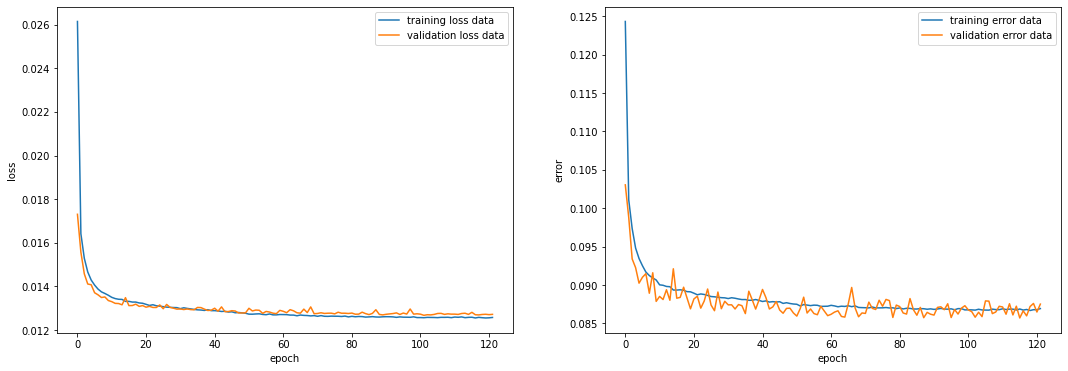

In [51]:
modelES.evaluate(XVALID, YVALID)
print("Last Val Loss: %s" % historyES.history['val_loss'][-1])
print("Last Val MAE: %s" % historyES.history['val_mae'][-1])
print(historyES.params)
learning_curves(historyES)

print("Time (sec): %s" % callBackTime)

## **Iterative feature removal & selection**

### Significance (importance) of each feature

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error

importance_feature_columns = []
importance_feature = []
for index in range(1, dataset.shape[1]):
    ## Get the column
    X = dataset[dataset.columns[index]].values
    Y = dataset['age'].values

    ## Index for 30%
    index_30percent = int(0.3 * len(dataset_np[:, 0]))

    ## Split into training and validation
    XVALID = X[:index_30percent]
    YVALID = Y[:index_30percent]
    
    XTRAIN = X[index_30percent:]
    YTRAIN = Y[index_30percent:]

    ## Mean normalization
    min = XTRAIN.min(axis = 0) 
    max = XTRAIN.max(axis = 0) 
    mean = XTRAIN.mean(axis = 0)
    XTRAIN = (XTRAIN - mean) / (max - min)
    XVALID = (XVALID - mean) / (max - min)

    ## Rescaling
    Ymax = YTRAIN.max()
    YTRAIN = YTRAIN / Ymax
    YVALID = YVALID / Ymax

    ## Callback
    callback_a = ModelCheckpoint(filepath = "feature_removal.hdf5", monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=0)

    ## Model
    model = Sequential()
    model.add(Dense(13, input_dim=1, activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(1, activation='linear'))

    ## Compile Model
    model.compile(loss='mse', optimizer = 'adam', metrics=['mae'])
    history = model.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs=1024, batch_size=100, callbacks=[callback_a, callback_b], verbose=1)
    
    ## Store MAE
    prediction = model.predict(XVALID, verbose=0)
    mae = mean_absolute_error(YVALID, prediction)
    importance_feature_columns.append(dataset.columns[index])
    importance_feature.append(mae)
# ~~~

print(importance_feature_columns)
print(importance_feature)

Epoch 1/1024
207/228 [==========================>...] - ETA: 0s - loss: 0.0614 - mae: 0.1927
Epoch 00001: val_loss improved from inf to 0.02236, saving model to feature_removal.hdf5
228/228 [==============================] - 1s 3ms/step - loss: 0.0578 - mae: 0.1861 - val_loss: 0.0224 - val_mae: 0.1221
Epoch 2/1024
221/228 [============================>.] - ETA: 0s - loss: 0.0224 - mae: 0.1222
Epoch 00002: val_loss improved from 0.02236 to 0.02231, saving model to feature_removal.hdf5
228/228 [==============================] - 1s 3ms/step - loss: 0.0224 - mae: 0.1222 - val_loss: 0.0223 - val_mae: 0.1215
Epoch 3/1024
218/228 [===========================>..] - ETA: 0s - loss: 0.0223 - mae: 0.1217
Epoch 00003: val_loss improved from 0.02231 to 0.02210, saving model to feature_removal.hdf5
228/228 [==============================] - 1s 3ms/step - loss: 0.0222 - mae: 0.1217 - val_loss: 0.0221 - val_mae: 0.1207
Epoch 4/1024
224/228 [============================>.] - ETA: 0s - loss: 0.0220 - ma

In [ ]:
y_pos = np.arange(len(importance_feature_columns))

plt.figure(figsize=(8, 8))
plt.bar(y_pos, importance_feature, align='center', alpha=0.5)
plt.xticks(y_pos, importance_feature_columns, fontsize=10, rotation=45)
plt.ylabel('MAE')
plt.title('Significance (importance) of each feature')

plt.show()

In [ ]:
# Ranking the features by their importance
import operator

dictionary_mae = {}
for index, name in enumerate(importance_feature_columns):
    dictionary_mae[name] = importance_feature[index]

dictionary_mae = sorted(dictionary_mae.items(), key=operator.itemgetter(1))
print(dictionary_mae)

### Performance drop after removing less important features

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error

performance_feature_columns = []
performance_feature = []
for index in range(1, dataset.shape[1]):
    # Get the column
    X = dataset.drop([dataset.columns[index]], axis='columns').values
    Y = dataset['age'].values

    # Index for 30%
    index_30percent = int(0.3 * len(dataset_np[:, 0]))

    # Split into training and validation
    XVALID = X[:index_30percent]
    YVALID = Y[:index_30percent]
    
    XTRAIN = X[index_30percent:]
    YTRAIN = Y[index_30percent:]

    ## Mean normalization
    min = XTRAIN.min(axis = 0) 
    max = XTRAIN.max(axis = 0) 
    mean = XTRAIN.mean(axis = 0)
    XTRAIN = (XTRAIN - mean) / (max - min)
    XVALID = (XVALID - mean) / (max - min)

    ## Rescaling
    Ymax = YTRAIN.max()
    YTRAIN = YTRAIN / Ymax
    YVALID = YVALID / Ymax

    # Callback
    callback_a = ModelCheckpoint(filepath = "feature_removal.hdf5", monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=0)

    # Model
    model = Sequential()
    model.add(Dense(13, input_dim=len(XTRAIN[0, :]), activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # Compile Model
    model.compile(loss='mse', optimizer = 'adam', metrics=['mae'])
    history = model.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs=1024, batch_size=100, callbacks=[callback_a, callback_b], verbose=1)
    
    # Store MAE
    prediction = model.predict(XVALID, verbose=0)
    mae = mean_absolute_error(YVALID, prediction)
    performance_feature_columns.append(dataset.columns[index])
    performance_feature.append(mae)
# ~~~

print(performance_feature_columns)
print(performance_feature)

In [ ]:
y_pos = np.arange(len(performance_feature_columns))

plt.figure(figsize=(8, 8))
plt.bar(y_pos, performance_feature, align='center', alpha=0.5)
plt.xticks(y_pos, performance_feature_columns, fontsize=10, rotation=45)
plt.ylabel('MAE')
plt.title('Performance drop after removing less important features')

plt.show()

In [ ]:
# Ranking the features by their performance
import operator

dictionary_mae = {}
for index, name in enumerate(performance_feature_columns):
    dictionary_mae[name] = performance_feature[index]

dictionary_mae = sorted(dictionary_mae.items(), key=operator.itemgetter(1))
print(dictionary_mae)